In [1]:
# 各種インポート
import os
import random as rn
from keras import backend as K
import keras
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression #線形回帰のライブラリ
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from tensorflow.compat.v1.keras.models import load_model
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from collections import defaultdict
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation,Flatten
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from keras.utils.np_utils import to_categorical
from sklearn.tree import export_graphviz
import tensorflow as tf
import csv
from scipy import stats

Using TensorFlow backend.


# 前処理

説明変数を変える<br>
外れ値の処理<br>
ニューラルネットワークのパラメータ<br>

In [2]:
df = pd.read_csv("measurements.csv")

In [3]:
# データの情報を確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null float64
consume          388 non-null float64
speed            388 non-null int64
temp_inside      376 non-null float64
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill_liters    13 non-null float64
refill gas       13 non-null object
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB


In [4]:
# データの先頭5行を表示
df.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill_liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


In [5]:
df["temp_inside"] = df.temp_inside.fillna(df["temp_inside"].mean())

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null float64
consume          388 non-null float64
speed            388 non-null int64
temp_inside      388 non-null float64
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill_liters    13 non-null float64
refill gas       13 non-null object
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB


In [7]:
df["temp_difference"] = df["temp_inside"] - df["temp_outside"]

In [8]:
# 文字列があるため、ダミー変数を使用して数値化
df = pd.get_dummies(df)

# 特徴選択

In [9]:
#  estimatorにモデルをセット
# 今回は回帰問題であるためLinearRegressionを使用
estimator = LinearRegression(normalize=False)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
# 汎化誤差を計算するためにクロスバリデーションをしている
rfecv = RFECV(estimator, cv=5, scoring='neg_mean_absolute_error')

In [10]:
train_data = df[['distance', "speed", "temp_difference", 'gas_type_E10',"gas_type_SP98", 'AC', 'rain', 'sun']]
train_label = df["consume"]

X = train_data.values
y = train_label.values

# fitで特徴選択を実行
rfecv.fit(X, y)

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
   min_features_to_select=1, n_jobs=None,
   scoring='neg_mean_absolute_error', step=1, verbose=0)

In [11]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[5 3 1 4 2 1 1 1]


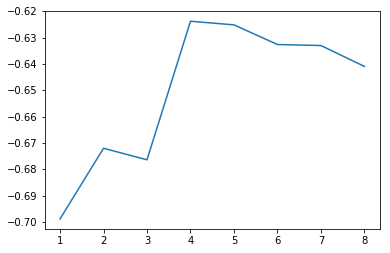

In [12]:
# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
# 横軸は、説明円数の数になる
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [13]:
# rfecv.support_でランキング1位以外はFalseとするindexを取得できる
# Trueになっている特徴を使用すれば汎化誤差は最小となる
rfecv.support_

array([False, False,  True, False, False,  True,  True,  True])

In [14]:
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
remove_idx = ~rfecv.support_
remove_idx

array([ True,  True, False,  True,  True, False, False, False])

In [15]:
remove_feature = train_data.columns[remove_idx]
remove_feature

Index(['distance', 'speed', 'gas_type_E10', 'gas_type_SP98'], dtype='object')

In [16]:
X = train_data.drop(remove_feature,axis=1)
index = X.columns

In [17]:
index

Index(['temp_difference', 'AC', 'rain', 'sun'], dtype='object')

In [18]:
# 正規分布の2δ以内に入る値を採用する。またそれ以外は外れ値として削除
# 標本平均
mean = np.mean(df["temp_difference"])
# 標本分散
variance = np.var(df["temp_difference"])

temp = []
x = np.array(temp,dtype = np.float32) 
x_1 = np.array(temp,dtype = np.float32) 

for i in df["temp_difference"]:
    if (i-mean)/variance < 1.96:
         x = np.append(x,i)
    else:
         x_1 = np.append(x_1,i)
        
    if (i-mean)/variance > -1.96:
         x = np.append(x,i)
    else:
         x_1 = np.append(x_1,i)
print("2δ以内",len(x))
print("2δ以外",len(x_1))

2δ以内 776
2δ以外 0


今回は外れ値はなかったため、削除しない

# scilit-learnで決定木を生成

score= -0.20963352254810008
決定木_MSE_訓練誤差 =  0.78544197377474

決定木_MSE_汎化誤差 =  0.831990867596118
[0.88104703 0.00412407 0.10846683 0.00636207]


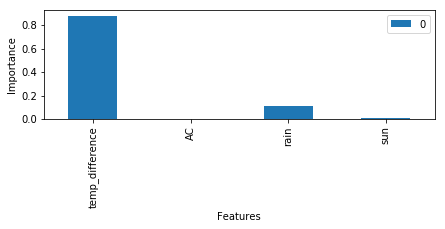

     temp_difference  AC  rain  sun
138        11.500000   0     1    0
363        -1.000000   0     0    0
299         7.000000   1     0    1
57         13.500000   0     0    0
73         13.500000   0     0    0
43         14.500000   0     0    0
198         7.500000   0     0    0
180        22.500000   0     0    0
7          15.500000   0     0    0
339        -2.000000   0     0    0
223        11.500000   0     0    0
70          9.500000   0     0    0
222        12.500000   0     0    0
218        10.500000   0     0    0
108        17.000000   0     0    0
373        -3.000000   1     0    0
44         14.500000   0     0    0
129        24.500000   0     0    0
179        21.000000   0     0    0
319         1.000000   0     0    1
122        20.000000   0     0    0
22         20.500000   0     0    0
199         8.500000   0     0    0
380        -2.500000   0     0    0
97         12.929521   0     0    0
140        11.500000   0     1    0
78         14.500000   0    

In [19]:
def mse(y,y_pred):
    mean_squared_error(y,y_pred)
    
    return mean_squared_error(y,y_pred)

# import decision_tree as dt
test_size = 0.2

X = df[['temp_difference', 'AC', 'rain', 'sun']]
y_0 = df["consume"]
y = y_0.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）}

clf = DecisionTreeRegressor(criterion="mse",splitter="best",max_depth=5,min_samples_split=3,min_samples_leaf=3,min_weight_fraction_leaf=0.0,max_features=None,random_state=1234)

clf = clf.fit(X_train,y_train)
mse1 = mse(y_test,clf.predict(X_test))
print("score=",clf.score(X_test,y_test))
print("決定木_MSE_訓練誤差 = ",(mse(y_train,clf.predict(X_train))))
print()
print("決定木_MSE_汎化誤差 = ",(mse(y_test,clf.predict(X_test))))
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_,index=['temp_difference', 'AC', 'rain', 'sun']).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

dot_data = StringIO() 
export_graphviz(clf,out_file=dot_data,
                   feature_names=['temp_difference', 'AC', 'rain', 'sun'],
                   class_names=["0","1","2"],
                   filled=True,rounded=True,
                   special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

decision = clf.predict(X_test)
print(X_test)

# ランダムフォレストの生成

In [20]:
def param():
    ret = {
#         "n_estimators":np.arange(1,500,1),
        "criterion":["mse","mae"],
        "max_depth":np.arange(1,5,1),
        "min_samples_split":np.arange(2,5,1),
        "min_samples_leaf":np.arange(2,5,1)
    }
    return ret

gscv = GridSearchCV(RandomForestRegressor(),param(),cv=5,verbose=2)
gscv.fit(X_train,y_train)
    
gs_result = pd.DataFrame.from_dict(gscv.cv_results_)
# print(gs_result)
    
best1 = gscv.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=1, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=2, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=4, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=1, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=2 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4 


C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4, total=   0.0s


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    6.3s finished
C:\Users\N394\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\N394\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\N394\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\N394\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:1

In [21]:
best1

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

R2_score= -0.006441477674000495
ランダムフォレスト_MSE_訓練誤差 =  0.8607337181018053

ランダムフォレスト_MSE_汎化誤差 =  0.6922345508669665
[0.82772558 0.04718994 0.1205341  0.00455039]


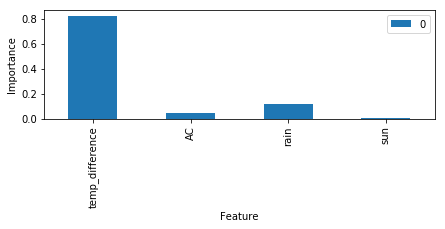

In [22]:
clf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

clf.fit(X_train,y_train)
mse2 = mse(y_test,clf.predict(X_test))
print("R2_score=",clf.score(X_test,y_test))
print("ランダムフォレスト_MSE_訓練誤差 = ",(mse(y_train,clf.predict(X_train))))
print()
print("ランダムフォレスト_MSE_汎化誤差 = ",(mse(y_test,clf.predict(X_test))))
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_,index=['temp_difference', 'AC', 'rain', 'sun']).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show

random = clf.predict(X_test)

# アダブースト

In [23]:
def param():
    ret = {
#         "n_estimators":np.arange(1,500,1),
        "criterion":["mse","mae"],
        "max_depth":np.arange(1,5,1),
        "min_samples_split":np.arange(2,5,1),
        "min_samples_leaf":np.arange(2,5,1)
    }
    return ret

gscv = GridSearchCV(DecisionTreeRegressor(),param(),cv=5,verbose=2)
gscv.fit(X_train,y_train)
    
gs_result = pd.DataFrame.from_dict(gscv.cv_results_)
# print(gs_result)
    
best2 = gscv.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2 
[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2 
[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2 
[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2 
[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2 
[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3 
[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3 
[CV]  criterion=mse, max_depth=1, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, ma

[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3 
[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3 
[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3 
[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3 
[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4 
[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4 
[CV]  criterion=mse, max_depth=2, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, ma

[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4 
[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4 
[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4 
[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4 
[CV]  criterion=mse, max_depth=3, min_samples_leaf=2, min_samples_split=4, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2 
[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2 
[CV]  criterion=mse, max_depth=3, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, ma

[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2 
[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2 
[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2 
[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2 
[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=2, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3 
[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3 
[CV]  criterion=mse, max_depth=4, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mse, ma

[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3 
[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3 
[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3 
[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3 
[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4 
[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4 
[CV]  criterion=mae, max_depth=1, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, ma

[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4 
[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4 
[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4 
[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4 
[CV]  criterion=mae, max_depth=2, min_samples_leaf=3, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2 
[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2 
[CV]  criterion=mae, max_depth=2, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, ma

[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2 
[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2 
[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2 
[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2 
[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=2, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3 
[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3 
[CV]  criterion=mae, max_depth=3, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, ma

[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3 
[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3 
[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3 
[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3 
[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=3, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4 
[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4 
[CV]  criterion=mae, max_depth=4, min_samples_leaf=4, min_samples_split=4, total=   0.0s
[CV] criterion=mae, ma

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    2.8s finished
C:\Users\N394\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\N394\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\N394\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

In [24]:
best2

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [25]:
def param():
    ret = {
        "alpha":np.logspace(-2,4,24)
    }
    return ret

gscv = GridSearchCV(Ridge(),param(),cv=5,scoring="r2",return_train_score=True)
gscv.fit(X_train,y_train)
    
gs_result = pd.DataFrame.from_dict(gscv.cv_results_)
# print(gs_result)
    
best3 = gscv.best_estimator_

best3

Ridge(alpha=13.503140378698722, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

R2_score= -0.4804895119490582
アダブースト_MSE_訓練誤差 =  0.8796968138581994

アダブースト_MSE_汎化誤差 =  1.0182867211870532
[0.79969777 0.08424812 0.11180408 0.00425003]


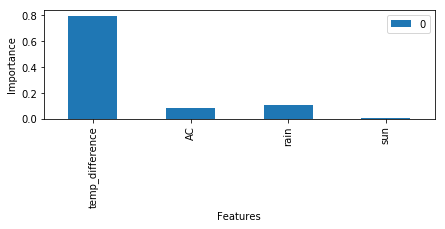

In [26]:
clf = AdaBoostRegressor(DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best'),n_estimators=500,random_state=1234)

clf.fit(X_train,y_train)
mse3 = mse(y_test,clf.predict(X_test))
print("R2_score=",clf.score(X_test,y_test))
print("アダブースト_MSE_訓練誤差 = ",(mse(y_train,clf.predict(X_train))))
print()
print("アダブースト_MSE_汎化誤差 = ",(mse(y_test,clf.predict(X_test))))
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_,index=['temp_difference', 'AC', 'rain', 'sun']).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

adaboost = clf.predict(X_train)

In [27]:
# 各モデル準備
random_state = 1234
X_train_valid, X_meta_valid, y_train_valid, y_meta_valid = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.5, random_state=1234)

model1 =   AdaBoostRegressor(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=1234, verbose=0, warm_start=False),n_estimators=500,random_state=1234)
model2 =   DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')

model1.fit(X_train,y_train)

model2.fit(X_train,y_train)

model_pre_1 = model1.predict(X_valid)

model_pre_2 = model2.predict(X_valid)

model1.fit(X_train,y_train)

model2.fit(X_train,y_train)

model_pre_1_1 = model1.predict(X_train)

model_pre_2_1 = model2.predict(X_train)

In [28]:
# メタモデルの学習
stacked_predictions = np.column_stack((model_pre_1,model_pre_2))
stacked_predictions_1 = np.column_stack((model_pre_1_1,model_pre_2_1))

meta_model = LinearRegression()
meta_model_1 = LinearRegression()
meta_model.fit(stacked_predictions,y_valid)
meta_model_1.fit(stacked_predictions_1,y_valid)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [29]:
# 結果の検証
valid_pred_1 = model1.predict(X_meta_valid)
valid_pred_2 = model2.predict(X_meta_valid)

valid_pred_1_1 = model1.predict(X_train_valid)
valid_pred_2_1 = model2.predict(X_train_valid)

stacked_valid_predictions = np.column_stack((valid_pred_1,valid_pred_2))
meta_valid_pred = meta_model.predict(stacked_valid_predictions)
mse4 = mse(y_meta_valid, meta_valid_pred)

stacked_valid_predictions_1 = np.column_stack((valid_pred_1_1,valid_pred_2_1))
meta_valid_pred_1 = meta_model.predict(stacked_valid_predictions_1)
mse4_1 = mse(y_train_valid, meta_valid_pred_1)

meta1 = meta_model.predict(stacked_valid_predictions_1)

In [30]:
print ("r2_score of model 1_汎化誤差: {:.4f}".format(r2_score(y_meta_valid, valid_pred_1)))
print ("r2_score of model 2_汎化誤差: {:.4f}".format(r2_score(y_meta_valid, valid_pred_2)))
print ("r2_score of meta model_汎化誤差: {:.4f}".format(r2_score(y_meta_valid, meta_valid_pred)))
print ("スタッキング_MSE_汎化誤差: {:.4f}".format(mean_squared_error(y_meta_valid, meta_valid_pred)))
print()
print ("r2_score of model 1_汎化誤差: {:.4f}".format(r2_score(y_train_valid, valid_pred_1_1)))
print ("r2_score of model 2_汎化誤差: {:.4f}".format(r2_score(y_train_valid, valid_pred_2_1)))
print ("r2_score of meta model_汎化誤差: {:.4f}".format(r2_score(y_train_valid, meta_valid_pred_1)))
print ("スタッキング_MSE_汎化誤差: {:.4f}".format(mean_squared_error(y_train_valid, meta_valid_pred_1)))

r2_score of model 1_汎化誤差: -0.1241
r2_score of model 2_汎化誤差: -0.1026
r2_score of meta model_汎化誤差: -0.1510
スタッキング_MSE_汎化誤差: 0.7917

r2_score of model 1_汎化誤差: 0.2510
r2_score of model 2_汎化誤差: 0.1674
r2_score of meta model_汎化誤差: 0.2517
スタッキング_MSE_汎化誤差: 0.8665


決定係数がとても低いため、上記のスタッキングは意味をなしていない<br>
二つのモデルを用意し、それぞれで学習し。予測させる。<br>
それらの予測値と分割したテストデータをメタモデルの引数として投入する。<br>
この処理は、各モデルの処理がどの程度信頼できるのかを検証している。<br>
そして最後に結果の検証として、<br>
メタモデルの予測値とそれぞれの予測値を用いてR2_scoreを求めている<br>
→しかし上手くいかない。精度がとても低くモデルとして完成度が低い

In [31]:
import os
import numpy as np
import random as rn
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(7)
rn.seed(7)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

from keras import backend as K

tf.set_random_seed(7)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [32]:
# ニューラルネットワークの実装

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）}

model = Sequential()
model.add(Dense(6, activation='relu', 
                 kernel_initializer=tf.keras.initializers.he_normal(seed=666), 
                 input_dim=len(X_train.keys())))
model.add(Dense(10, activation="relu",input_dim=1))
model.add(Dense(1))

# ------ 最適化手法 ------
# sgd = SGD(lr=0.1, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss="mean_squared_error",
              optimizer=adam,
             metrics = ["mse"])

W1008 11:14:28.592953 15716 deprecation.py:506] From C:\Users\N394\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 310 samples, validate on 78 samples
Epoch 1/100
310/310 [==============================] - ETA: 3s - loss: 51.5776 - mean_squared_error: 51.57 - 0s 757us/sample - loss: 10.8066 - mean_squared_error: 10.8066 - val_loss: 3.5430 - val_mean_squared_error: 3.5430
Epoch 2/100
310/310 [==============================] - ETA: 0s - loss: 5.3712 - mean_squared_error: 5.37 - 0s 111us/sample - loss: 3.0488 - mean_squared_error: 3.0488 - val_loss: 2.1231 - val_mean_squared_error: 2.1231
Epoch 3/100
310/310 [==============================] - ETA: 0s - loss: 1.3408 - mean_squared_error: 1.34 - 0s 129us/sample - loss: 2.1022 - mean_squared_error: 2.1022 - val_loss: 1.6301 - val_mean_squared_error: 1.6301
Epoch 4/100
310/310 [==============================] - ETA: 0s - loss: 1.0669 - mean_squared_error: 1.06 - 0s 145us/sample - loss: 1.6001 - mean_squared_error: 1.6001 - val_loss: 1.1536 - val_mean_squared_error: 1.1536
Epoch 5/100
310/310 [==============================] - ETA: 0s - loss: 0.84

Epoch 38/100
310/310 [==============================] - ETA: 0s - loss: 0.5234 - mean_squared_error: 0.52 - 0s 129us/sample - loss: 1.0067 - mean_squared_error: 1.0067 - val_loss: 0.7128 - val_mean_squared_error: 0.7128
Epoch 39/100
310/310 [==============================] - ETA: 0s - loss: 1.1567 - mean_squared_error: 1.15 - 0s 111us/sample - loss: 1.0181 - mean_squared_error: 1.0181 - val_loss: 0.7685 - val_mean_squared_error: 0.7685
Epoch 40/100
310/310 [==============================] - ETA: 0s - loss: 0.2676 - mean_squared_error: 0.26 - 0s 110us/sample - loss: 1.0109 - mean_squared_error: 1.0109 - val_loss: 0.6750 - val_mean_squared_error: 0.6750
Epoch 41/100
310/310 [==============================] - ETA: 0s - loss: 0.6791 - mean_squared_error: 0.67 - 0s 114us/sample - loss: 0.9857 - mean_squared_error: 0.9857 - val_loss: 0.6820 - val_mean_squared_error: 0.6820
Epoch 42/100
310/310 [==============================] - ETA: 0s - loss: 0.3580 - mean_squared_error: 0.35 - 0s 170us/sam

Epoch 75/100
310/310 [==============================] - ETA: 0s - loss: 0.5742 - mean_squared_error: 0.57 - 0s 93us/sample - loss: 1.0043 - mean_squared_error: 1.0043 - val_loss: 0.7206 - val_mean_squared_error: 0.7206
Epoch 76/100
310/310 [==============================] - ETA: 0s - loss: 0.7339 - mean_squared_error: 0.73 - 0s 106us/sample - loss: 0.9933 - mean_squared_error: 0.9933 - val_loss: 0.6902 - val_mean_squared_error: 0.6902
Epoch 77/100
310/310 [==============================] - ETA: 0s - loss: 4.1813 - mean_squared_error: 4.18 - 0s 105us/sample - loss: 0.9633 - mean_squared_error: 0.9633 - val_loss: 0.6714 - val_mean_squared_error: 0.6714
Epoch 78/100
310/310 [==============================] - ETA: 0s - loss: 0.3290 - mean_squared_error: 0.32 - 0s 96us/sample - loss: 0.9731 - mean_squared_error: 0.9731 - val_loss: 0.7488 - val_mean_squared_error: 0.7488
Epoch 79/100
310/310 [==============================] - ETA: 0s - loss: 0.4593 - mean_squared_error: 0.45 - 0s 100us/sampl

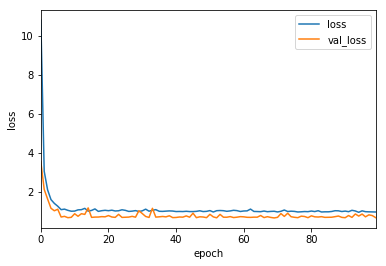

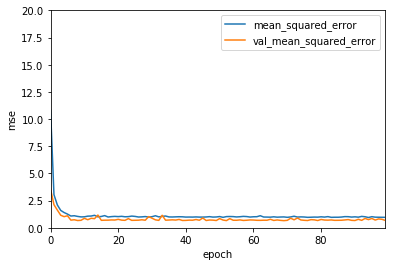

ニューラルネットワーク_MSE =  0.6749942887930458


In [33]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=100,
          batch_size=10,validation_data=(X_test, y_test))


# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["mean_squared_error", "val_mean_squared_error"]].plot()
plt.ylabel("mse")
plt.xlabel("epoch")
plt.ylim([0,20])
plt.show()

mse5 = mse(y_test,model.predict(X_test))
print("ニューラルネットワーク_MSE = ",(mse(y_test,model.predict(X_test))))

NN = model.predict(X_test)

In [34]:
# 保存
model.save('my_model.h5')
del model

# 読み込み
model = load_model('my_model.h5')

W1008 11:14:34.013532 15716 deprecation.py:506] From C:\Users\N394\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1008 11:14:34.036395 15716 deprecation.py:506] From C:\Users\N394\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [35]:
# モデル精度の比較
print("決定木_MSE = ",mse1)
print("ランダムフォレスト_MSE = ",mse2)
print("アダブースト_MSE = ",mse3)
print ("スタッキング_MSE =",mse4)
print("ニューラルネットワーク_MSE = ",mse5)

決定木_MSE =  0.831990867596118
ランダムフォレスト_MSE =  0.6922345508669665
アダブースト_MSE =  1.0182867211870532
スタッキング_MSE = 0.7916785275568433
ニューラルネットワーク_MSE =  0.6749942887930458


### 今回はニューラルネットワークのモデルが最も精度が良いことが分かった